This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



### Preparation

In [1]:
import os
os.chdir("/Users/cherie/Desktop/quantum-gates/src")  # or any folder that actually exists
print(os.getcwd())

/Users/cherie/Desktop/quantum-gates/src


In [2]:
import  qiskit, qiskit_aer, qiskit_ibm_runtime
print("Qiskit:", qiskit.__version__)
print("Aer:", qiskit_aer.__version__)
print("IBM Runtime:", qiskit_ibm_runtime.__version__)



Qiskit: 2.2.3
Aer: 0.17.2
IBM Runtime: 0.41.1


In [3]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

# 0) Point to the *parent* of the package folder
LOCAL_QG_PATH = r"../src"   # or r"C:\Users\npace\Desktop\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# 1) Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# 2) Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# 3) Invalidate import caches and import the local package
importlib.invalidate_caches()
print(os.getcwd())
import quantum_gates

print("Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import SurfaceCode
    
    


/Users/cherie/Desktop/quantum-gates/src
Using quantum_gates from: /Users/cherie/Desktop/quantum-gates/src/quantum_gates/__init__.py


In [4]:
# -------------------------------
# Create and load the fake backend
# -------------------------------

# dump_from_fake_backend.py
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters

# Pick a fake backend
backend = FakeBrisbane()  # 127 qubits; change to another Fake*V2 if import fails

### Create Circuit

X-stab at qubit 1 (r=0, c=1) -> neighbors [np.int64(6), np.int64(0), np.int64(2)] -> data: [np.int64(6), np.int64(0), np.int64(2)]
X-stab at qubit 3 (r=0, c=3) -> neighbors [np.int64(8), np.int64(2), np.int64(4)] -> data: [np.int64(8), np.int64(2), np.int64(4)]
X-stab at qubit 11 (r=2, c=1) -> neighbors [np.int64(6), np.int64(16), np.int64(10), np.int64(12)] -> data: [np.int64(6), np.int64(16), np.int64(10), np.int64(12)]
X-stab at qubit 13 (r=2, c=3) -> neighbors [np.int64(8), np.int64(18), np.int64(12), np.int64(14)] -> data: [np.int64(8), np.int64(18), np.int64(12), np.int64(14)]
X-stab at qubit 21 (r=4, c=1) -> neighbors [np.int64(16), np.int64(20), np.int64(22)] -> data: [np.int64(16), np.int64(20), np.int64(22)]
X-stab at qubit 23 (r=4, c=3) -> neighbors [np.int64(18), np.int64(22), np.int64(24)] -> data: [np.int64(18), np.int64(22), np.int64(24)]
Z-stab at qubit 5 (r=1, c=0) -> neighbors [np.int64(0), np.int64(10), np.int64(6)] -> data: [np.int64(0), np.int64(10), np.int64(6)]
Z

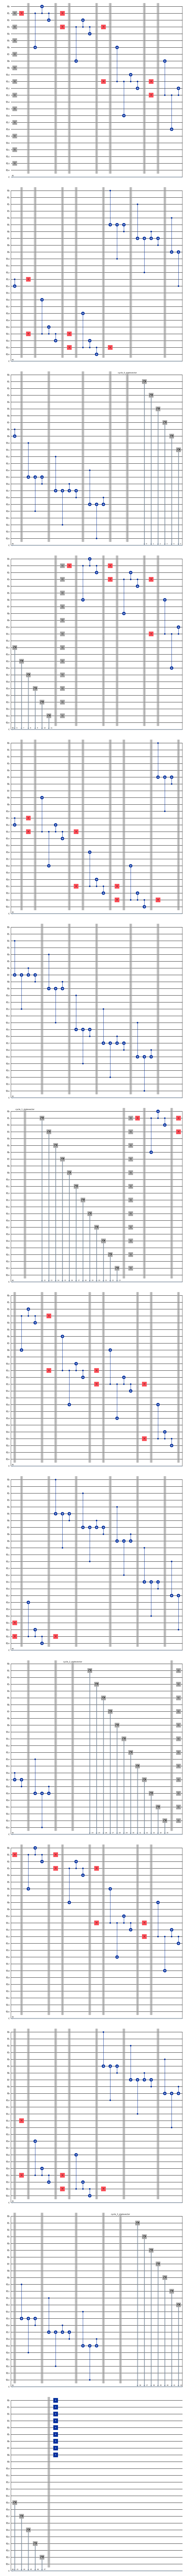

In [5]:
code = SurfaceCode(distance=2, cycles=4)
qc = code.qc
qc.x([0,1,2,3,4,5,6,7,8])  # introduce bit-flip errors on all data qubits
qc.draw("mpl")

In [6]:
mid_counts = code.run_surfacecode(noise = True)

TranspilerError: 'Unable to translate the operations in the circuit: {("barrier", 25), ("save_statevector", 25)} to the backend\'s (or manually specified) target basis: {"sx", "ecr", "reset", "if_else", "switch_case", "measure", "delay", "id", "for_loop", "x", "rz", "barrier", "snapshot", "store"}. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.transpiler.passes.BasisTranslator#translation-errors'

In [ ]:
code.plot_results(mid_counts, plot_each_shot=True)

#label=f"cycle_{cycle}_end"


In [18]:
# Simulate with Aer

sim = AerSimulator()
t_circ = code.qc
t_qc = transpile(t_circ, sim)
result = sim.run(t_qc, shots=2048).result()
counts = result.get_counts()


In [ ]:
t_qc.draw("mpl")    

In [ ]:
print("Aer All clbits counts:", counts)
plot_histogram(counts, title="Aer All classical bits")